## Network Simulation and Modeling

Goal: Given the two airline network models, we wish to simulate network traversals of each airline network:
 
--> A hub and spoke based system

--> A point-to-point based system



In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import gaussian_kde
from scipy.integrate import trapz
from scipy.stats import bernoulli
from tqdm import tqdm
import folium
import airportsdata

In [7]:
# extract the edge table 
edge_dataset = pd.read_csv("Database\FINAL_EDGE_TABLE.csv")
on_time_data = pd.read_csv('Database\FINAL_ON_TIME_DATA.csv')

def preprocess_data(df):
    '''
    Goal: Extract new edge attributes and reduce edge data table
    Parameters:
        df (pandas dataframe) input hub-spoke or point to point edge data
    Return:
        edge (pandas dataframe) cleaned output network edge data
    '''
    # create another column to preprocess the data and create new data table attributes
    df['net_profit'] = ( df['revenue'] * 1000 - df['total_operating_expense'] ) * df['Proportion of Seats filled']
    # extract route demand metric
    df['Demand_prop'] = df['passengers'] / df['seats']


    # drop additional columns that we wont need for simulation
    edge = df.filter(['Demand_prop', 'passengers','net_profit','Origin_Airport_Code','Destination_Airport_Code','Proportion of Seats filled','CANCELLED','citypair'],axis=1)
    # create a networkx graph from this edge dataset
    G = nx.from_pandas_edgelist(df = edge, source = 'Origin_Airport_Code', target = 'Destination_Airport_Code', 
                               edge_attr = ['CANCELLED', 'passengers','net_profit','Proportion of Seats filled','citypair','Demand_prop'])
    # convert graph to a directed graph
    G = G.to_directed()
    return G

p_2_p_Graph = preprocess_data(edge_dataset) 

In [21]:
# Let's check if there are any leafs in the Graph --> this will affect our simulation so we must 
# i.e. there exists many cycles in the graph
print([x for x in p_2_p_Graph.nodes() if p_2_p_Graph.in_degree(x)==0])

print([x for x in p_2_p_Graph.nodes() if p_2_p_Graph.out_degree(x)==0])

color=nx.get_edge_attributes(p_2_p_Graph,'passengers')
color[('EWR','PHX')]

'''adj_nodes = list(p_2_p_Graph.neighbors('EWR'))
demand=nx.get_edge_attributes(p_2_p_Graph,'Demand_prop')
node_demand_probs = [demand[i] for i in list(p_2_p_Graph.edges('EWR'))] 
node_demand_probs = node_demand_probs / np.sum(node_demand_probs)
next_ind = np.random.choice(np.arange(len(node_demand_probs)),size=1, p=node_demand_probs.astype(float))
next_node = adj_nodes[next_ind[0]]
next_node'''
color[('EWR','FLL')]


[]
[]


15247.0

$Pnet_{adjusted} = (Revenue - Operating Expense) * Proportion of Seats Filled $

In [30]:
# random sampling from KDE distributions
def random_samples(citypair,metric):
    # Generate some example data
    # x ~ vector of data based on the following
    # filter data given citypair key and metric argument 
    fltrd = on_time_data.loc[on_time_data['citypair'] == citypair]
    x = (fltrd[metric].to_list())
    # Compute the KDE
    kde = gaussian_kde(x, bw_method='silverman')
    # Truncate the KDE to have support only over x > 0
    pdf_trunc = lambda x: kde(x) * (x >= 0)
    # Normalize the truncated PDF
    norm = trapz(pdf_trunc(np.linspace(0, np.max(x), 1000)), dx=np.max(x)/999)
    pdf_norm = lambda x: pdf_trunc(x) / norm
    # Define the inverse CDF
    x_vals = np.linspace(0, np.max(x), 1000)
    cdf_vals = np.cumsum(pdf_norm(x_vals)) * np.max(x) / 999
    inv_cdf = lambda y: np.interp(y, cdf_vals, x_vals)
    # Generate random samples using inverse transform sampling
    u = np.random.uniform(size=1)
    sample = inv_cdf(u)
    return sample


# define a function to simulate a flight traversal for a single flight through the network
# consider the total number of passengers transported 
def simulate_flight_traversal(G, start_node, N):
    '''
    Goal: simulate the flight traversal for a single aircraft starting at a given start airport
    Parameters:
        G: The airline network graph (networkx graph object)
        start_node: (string) the starting airport code
        N: number of traversals (edges) to make in the network
        start_node: the selected starting node for 
    Return:
        total_delay_time_accumlated
        total_cancellations
        total_profit generated by this aircraft  
    '''
    current_node = start_node

    # extract each attribute of the graph as a dict
    profits=nx.get_edge_attributes(G,'net_profit')
    cancel_prob=nx.get_edge_attributes(G,'CANCELLED')
    citypair=nx.get_edge_attributes(G,'citypair')
    passengers=nx.get_edge_attributes(G, 'passengers')

    total_profits = []
    total_dept_delays = []
    total_arrival_delays = []
    number_of_cancel = 0
    total_passengers_carried = 0

    number_of_legs = []

    for i in range(N):
        # get all adjacent nodes of the current node
        adj_nodes = list(G.neighbors(current_node))
        # randomly select a flight route given the transition probability 
        demand=nx.get_edge_attributes(G,'Demand_prop')
        
        node_demand_probs = [demand[i] for i in list(G.edges(current_node))] 
        node_demand_probs = node_demand_probs / np.sum(node_demand_probs)
        next_ind = np.random.choice(np.arange(len(node_demand_probs)),size=1, p=node_demand_probs.astype(float))
        next_node = adj_nodes[next_ind[0]]

        # calculate the profit of the flight route
        profit = profits[(current_node,next_node)]
        total_profits.append(profit)
        # extract the number of passengers carried on this flight
        pass_on_flight = passengers[(current_node, next_node)]
        total_passengers_carried += pass_on_flight

        # randomly simulate a delay time from the distribution
        code = citypair[(current_node,next_node)]
        try:
            dept_delay_time = random_samples(code, 'DEP_DELAY_NEW')[0]
            arr_delay_time = random_samples(code, 'ARR_DELAY_NEW')[0]
        except:
            dept_delay_time = 0
            arr_delay_time = 0

        total_dept_delays.append(dept_delay_time)
        total_arrival_delays.append(arr_delay_time)

        cancel_p = cancel_prob[(current_node,next_node)]
        # returns a bernoulli 0 or 1 value
        r = bernoulli.rvs(p=cancel_p, size=1)[0]
        number_of_cancel += r
        # move to the next node
        current_node = next_node
        number_of_legs.append(i+1)
        # return the profit generated by the flight traversal
    return np.sum(total_profits), np.sum(total_dept_delays), np.sum(total_arrival_delays), total_passengers_carried, number_of_cancel

## Next step
We repeat the simulate_flight_traversal for each airport as a starting node and compile all sampled attributes for comparison

In [18]:
def get_airports(edge_df):
    routes = edge_df['citypair'].to_list()
    routes = [i.split('-') for i in routes]
    airports = set([j for i in routes for j in i])
    return airports

p_2_p_airports = get_airports(edge_dataset)

##### We wish to now simulate the running totals for which we fix N and increment through all airports as the starting node

In [31]:
profits, dept_delay_time, arr_delay_time, total_pass, no_cancel = simulate_flight_traversal(G=p_2_p_Graph,start_node='EWR',N=5)

In [43]:
# This is the point to point model 
from tqdm import tqdm
# store each of the attributes into a data vector indexed along the airports list
profits_vec = []
dept_delay_vec = []
arr_delay_vec = []
cancellations_vec = []
number_of_pass = []

p_2_p_airports = [i for i in p_2_p_airports]
for loc in tqdm(p_2_p_airports):
    a,b,c,d,e = simulate_flight_traversal(G=p_2_p_Graph, start_node=loc,N=10)
    profits_vec.append(a)
    dept_delay_vec.append(b)
    arr_delay_vec.append(c)
    cancellations_vec.append(e)
    number_of_pass.append(d)

100%|██████████| 85/85 [03:44<00:00,  2.64s/it]


In [44]:
# Use Law of large numbers

print('expected value of profits', np.mean(profits_vec))
print('expected value of dept delay time', np.mean(dept_delay_vec))
print('expected value of arr delay time', np.mean(arr_delay_vec))
print('expected value of no. of cancellations', np.mean(cancellations_vec))
print('total number of passengers', np.mean(number_of_pass))

expected value of profits 14268278.625001898
expected value of dept delay time 272.4918544377167
expected value of arr delay time 228.39518563639456
expected value of no. of cancellations 0.07058823529411765
total number of passengers 337184.29411764705


### Visualizations and Results

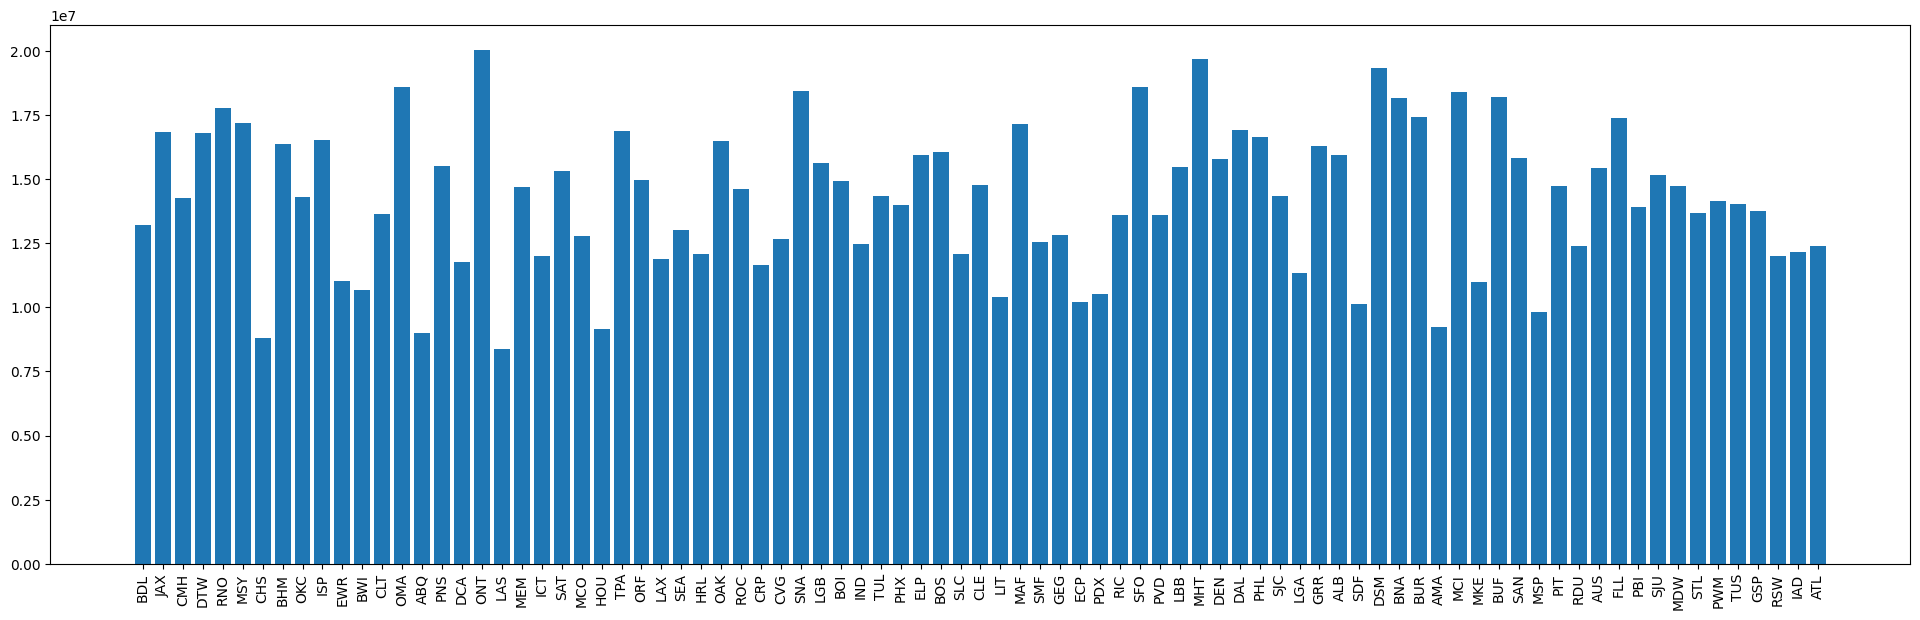

In [45]:
# plot which starting airport produces the highest overall profit in the long run 
fig_1 = plt.figure(figsize = (24,7), facecolor='w',edgecolor='k')

plt.bar(p_2_p_airports, profits_vec)
plt.xticks(rotation=90)
plt.show()

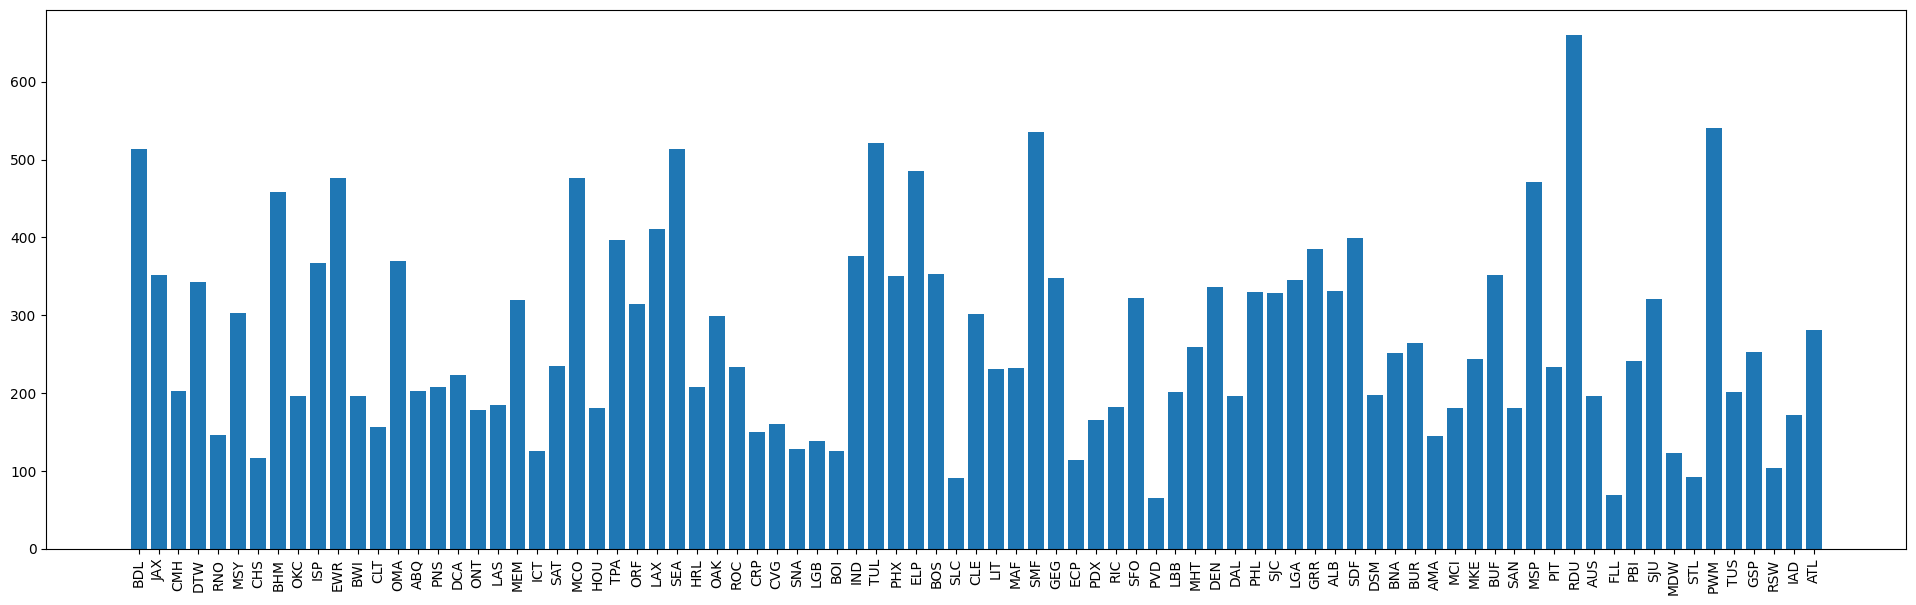

In [46]:
# plot which starting airport produces the highest overall profit in the long run 
fig_1 = plt.figure(figsize = (24,7), facecolor='w',edgecolor='k')

plt.bar(p_2_p_airports, dept_delay_vec)
plt.xticks(rotation=90)
plt.show()

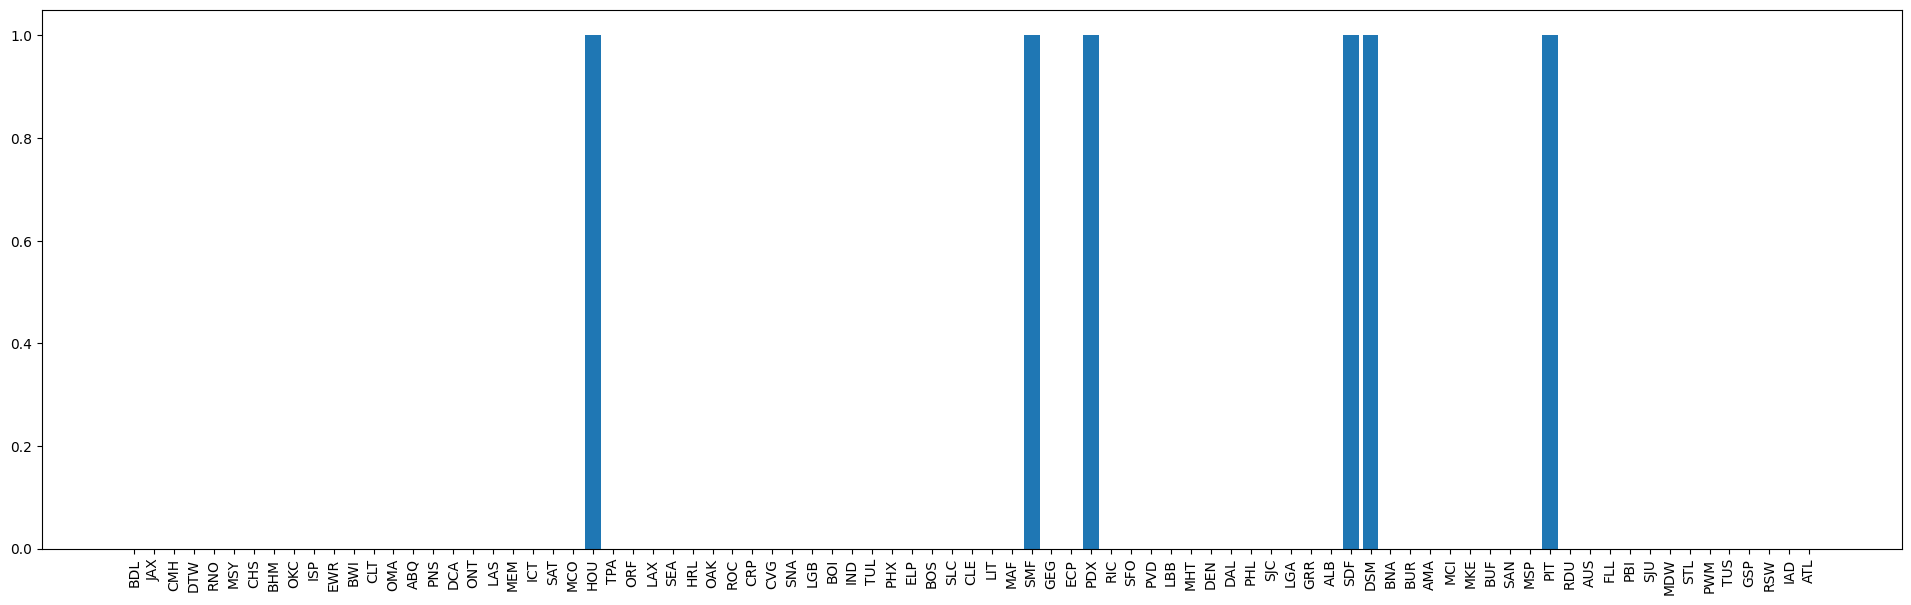

In [47]:
# plot which starting airport produces the highest overall profit in the long run 
fig_1 = plt.figure(figsize = (24,7), facecolor='w',edgecolor='k')

plt.bar(p_2_p_airports, cancellations_vec)
plt.xticks(rotation=90)
plt.show()

### Generate Path Visualizations

In [48]:
# import airports data code log
import airportsdata
import folium
airports = airportsdata.load('IATA')  # key is the IATA location code
print(airports['JFK'])

{'icao': 'KJFK', 'iata': 'JFK', 'name': 'John F Kennedy International Airport', 'city': 'New York', 'subd': 'New York', 'country': 'US', 'elevation': 13.0, 'lat': 40.6399277777778, 'lon': -73.7786925, 'tz': 'America/New_York', 'lid': 'JFK'}


In [49]:
def visualize_route(G, start_node, N):
    # define a function to simulate a flight traversal for a sinl
    current_node = start_node

    # extract each attribute of the graph as a dict
    profits=nx.get_edge_attributes(G,'net_profit')
    cancel_prob=nx.get_edge_attributes(G,'CANCELLED')
    citypair=nx.get_edge_attributes(G,'citypair')

    total_profits = []
    total_dept_delays = []
    total_arrival_delays = []
    number_of_cancel = 0

    number_of_legs = []

    visited_airports = [start_node]

    for i in range(N):
        # get all adjacent nodes of the current node
        adj_nodes = list(G.neighbors(current_node))
        # randomly select a flight route given the transition probability 
        demand=nx.get_edge_attributes(p_2_p_Graph,'Demand_prop')
        node_demand_probs = [demand[i] for i in list(p_2_p_Graph.edges(current_node))] 
        node_demand_probs = node_demand_probs / np.sum(node_demand_probs)
        next_ind = np.random.choice(np.arange(len(node_demand_probs)),size=1, p=node_demand_probs.astype(float))
        next_node = adj_nodes[next_ind[0]]

        # calculate the profit of the flight route
        profit = profits[(current_node,next_node)]
        total_profits.append(profit)
        # extract 
        # randomly simulate a delay time from the distribution
        code = citypair[(current_node,next_node)]
        try:
            dept_delay_time = random_samples(code, 'DEP_DELAY_NEW')[0]
            arr_delay_time = random_samples(code, 'ARR_DELAY_NEW')[0]
        except:
            dept_delay_time = 0
            arr_delay_time = 0

        total_dept_delays.append(dept_delay_time)
        total_arrival_delays.append(arr_delay_time)

        cancel_p = cancel_prob[(current_node,next_node)]
        # returns a bernoulli 0 or 1 value
        r = bernoulli.rvs(p=cancel_p, size=1)[0]
        number_of_cancel += r
        # move to the next node
        current_node = next_node
        visited_airports.append(next_node)
        number_of_legs.append(i+1)
        # return the profit generated by the flight traversal

        # visualize the route
    # store the long and lat coordinates
    locations_stored = []
    for j in visited_airports:
        coords = [airports[j]['lat'], airports[j]['lon']]
        locations_stored.append(coords)
    print('Cancelled Flights on this route:', number_of_cancel)
    print('Total Departure Delay Time on this route:', sum(total_dept_delays))
    print('Total Arrival Delay Time on this route:', sum(total_arrival_delays))
    print('Profit generated', sum(total_profits))
    print('Avg Profit on each leg', np.mean(total_profits))
    print('Path:', visited_airports)

    map = folium.Map(location=locations_stored[0], zoom_start=3.5, width=700, height=400, tiles='Cartodb Positron')
    # Add markers for each airport on the route
    for i in range(len(locations_stored)):
        folium.Marker(location=locations_stored[i], popup=visited_airports[i]).add_to(map)
    #folium.Marker(location=locations_stored[-1], popup=visited_airports[-1]).add_to(map)
    folium.PolyLine(locations=locations_stored, color='red').add_to(map)
    #display map
    return map 

In [50]:
visualize_route(p_2_p_Graph, 'BWI', 10)

Cancelled Flights on this route: 0
Total Departure Delay Time on this route: 265.41233781097355
Total Arrival Delay Time on this route: 58.396930124576535
Profit generated 15964805.376277488
Avg Profit on each leg 1596480.537627749
Path: ['BWI', 'LAX', 'PDX', 'LAX', 'DAL', 'AUS', 'ATL', 'PHL', 'HOU', 'CLT', 'BWI']


## Hub and Spoke Network Model Simulation

4 hub and spoke airline network models extracted

In [51]:
import warnings
# suppress all warnings
warnings.filterwarnings('ignore')

In [52]:
hub_spoke_model_1 = pd.read_csv("Database/subset_1.csv")
identifiers1 = hub_spoke_model_1['citypair'].to_list()
hub_spoke_model_1 = edge_dataset[edge_dataset['citypair'].isin(identifiers1)]
h_s_graph_1 = preprocess_data(hub_spoke_model_1)
h_s_graph_1_airports = get_airports(hub_spoke_model_1)

# code cell for hub and spoke model 1

from tqdm import tqdm
# store each of the attributes into a data vector indexed along the airports list
profits_vec_h1 = []
dept_delay_vec_h1 = []
arr_delay_vec_h1 = []
cancellations_vec_h1 = []
number_of_pass_h1 = []
h_s_1_airports = [i for i in h_s_graph_1_airports]
for loc in tqdm(h_s_1_airports):
    a,b,c,d,e = simulate_flight_traversal(G=h_s_graph_1, start_node=loc,N=10)
    profits_vec_h1.append(a)
    dept_delay_vec_h1.append(b)
    arr_delay_vec_h1.append(c)
    number_of_pass_h1.append(d)
    cancellations_vec_h1.append(e)

100%|██████████| 77/77 [02:50<00:00,  2.21s/it]


In [53]:
# Use Law of large numbers

print('expected value of profits', np.mean(profits_vec_h1), np.std(profits_vec_h1))
print('expected value of dept delay time', np.mean(dept_delay_vec_h1), np.std(dept_delay_vec_h1))
print('expected value of arr delay time', np.mean(arr_delay_vec_h1), np.std(arr_delay_vec_h1))
print('expected value of no. of cancellations', np.mean(cancellations_vec_h1), np.std(cancellations_vec_h1))
print('expected value of no. of total passengers', np.mean(number_of_pass_h1), np.std(number_of_pass_h1))

expected value of profits 17531322.93491607 2975249.6257093656
expected value of dept delay time 235.8557483049189 103.30865838624288
expected value of arr delay time 253.56271150717302 96.43810087413662
expected value of no. of cancellations 0.23376623376623376 0.48069494865770773
expected value of no. of total passengers 386151.3766233766 103432.98750323887


Hub and Spoke Model 2

In [54]:
hub_spoke_model_2 = pd.read_csv("Database/subset_2.csv")
identifiers2 = hub_spoke_model_2['citypair'].to_list()
hub_spoke_model_2 = edge_dataset[edge_dataset['citypair'].isin(identifiers2)]
h_s_graph_2 = preprocess_data(hub_spoke_model_2)
h_s_graph_2_airports = get_airports(hub_spoke_model_2)

# code cell for hub and spoke model 2

from tqdm import tqdm
# store each of the attributes into a data vector indexed along the airports list
profits_vec_h2 = []
dept_delay_vec_h2 = []
arr_delay_vec_h2 = []
cancellations_vec_h2 = []
number_of_pass_h2 = []

h_s_2_airports = [i for i in h_s_graph_2_airports]
for loc in tqdm(h_s_2_airports):
    a,b,c,d,e = simulate_flight_traversal(G=h_s_graph_2, start_node=loc,N=10)
    profits_vec_h2.append(a)
    dept_delay_vec_h2.append(b)
    arr_delay_vec_h2.append(c)
    number_of_pass_h2.append(d)
    cancellations_vec_h2.append(e)

100%|██████████| 81/81 [04:24<00:00,  3.27s/it]


In [55]:
print('expected value of profits', np.mean(profits_vec_h2), np.std(profits_vec_h2))
print('expected value of dept delay time', np.mean(dept_delay_vec_h2), np.std(dept_delay_vec_h2))
print('expected value of arr delay time', np.mean(arr_delay_vec_h2), np.std(arr_delay_vec_h2))
print('expected value of no. of cancellations', np.mean(cancellations_vec_h2), np.std(cancellations_vec_h2))
print('expected value of no. of total passengers', np.mean(number_of_pass_h2), np.std(number_of_pass_h2))

expected value of profits 16627721.669883799 3111045.010126853
expected value of dept delay time 251.2405770898013 136.35594823541092
expected value of arr delay time 262.05934055500654 110.66676220849773
expected value of no. of cancellations 0.18518518518518517 0.4190262407031393
expected value of no. of total passengers 394529.8024691358 112546.83433618551


Hub and spoke model 3

In [56]:
hub_spoke_model_3 = pd.read_csv("Database/subset_3.csv")
identifiers3 = hub_spoke_model_3['citypair'].to_list()
hub_spoke_model_3 = edge_dataset[edge_dataset['citypair'].isin(identifiers3)]
h_s_graph_3 = preprocess_data(hub_spoke_model_3)
h_s_graph_3_airports = get_airports(hub_spoke_model_3)


# code cell for hub and spoke model 3

from tqdm import tqdm
# store each of the attributes into a data vector indexed along the airports list
profits_vec_h3 = []
dept_delay_vec_h3 = []
arr_delay_vec_h3 = []
cancellations_vec_h3 = []
number_of_pass_h3 = []
h_s_3_airports = [i for i in h_s_graph_3_airports]
for loc in tqdm(h_s_3_airports):
    a,b,c,d,e = simulate_flight_traversal(G=h_s_graph_3, start_node=loc,N=10)
    profits_vec_h3.append(a)
    dept_delay_vec_h3.append(b)
    arr_delay_vec_h3.append(c)
    number_of_pass_h3.append(d)
    cancellations_vec_h3.append(e)

100%|██████████| 82/82 [04:46<00:00,  3.50s/it]


In [57]:
print('expected value of profits', np.mean(profits_vec_h3), np.std(profits_vec_h3))
print('expected value of dept delay time', np.mean(dept_delay_vec_h3), np.std(dept_delay_vec_h3))
print('expected value of arr delay time', np.mean(arr_delay_vec_h3), np.std(arr_delay_vec_h3))
print('expected value of no. of cancellations', np.mean(cancellations_vec_h3), np.std(cancellations_vec_h3))
print('expected value of no. of total passengers', np.mean(number_of_pass_h3), np.std(number_of_pass_h3))

expected value of profits 17110510.47583822 3293220.484215926
expected value of dept delay time 256.17349930841465 102.37553911206155
expected value of arr delay time 253.79070810384988 157.53883110368832
expected value of no. of cancellations 0.13414634146341464 0.3408094783532225
expected value of no. of total passengers 377792.5243902439 107239.67634391185


Hub and Spoke Model 4

In [58]:
hub_spoke_model_4 = pd.read_csv("Database/subset_4.csv")
identifiers4 = hub_spoke_model_4['citypair'].to_list()
hub_spoke_model_4 = edge_dataset[edge_dataset['citypair'].isin(identifiers4)]
h_s_graph_4 = preprocess_data(hub_spoke_model_4)
h_s_graph_4_airports = get_airports(hub_spoke_model_4)

# code cell for hub and spoke model 4

from tqdm import tqdm
# store each of the attributes into a data vector indexed along the airports list
profits_vec_h4 = []
dept_delay_vec_h4 = []
arr_delay_vec_h4 = []
cancellations_vec_h4 = []
number_of_pass_h4 = []

h_s_4_airports = [i for i in h_s_graph_4_airports]
for loc in tqdm(h_s_4_airports):
    a,b,c,d,e = simulate_flight_traversal(G=h_s_graph_4, start_node=loc,N=10)
    profits_vec_h4.append(a)
    dept_delay_vec_h4.append(b)
    arr_delay_vec_h4.append(c)
    number_of_pass_h4.append(d)
    cancellations_vec_h4.append(e)

100%|██████████| 76/76 [04:17<00:00,  3.39s/it]


In [59]:
print('expected value of profits', np.mean(profits_vec_h4), np.std(profits_vec_h4))
print('expected value of dept delay time', np.mean(dept_delay_vec_h4), np.std(dept_delay_vec_h4))
print('expected value of arr delay time', np.mean(arr_delay_vec_h4), np.std(arr_delay_vec_h4))
print('expected value of no. of cancellations', np.mean(cancellations_vec_h4), np.std(cancellations_vec_h4))
print('expected value of no. of total passengers', np.mean(number_of_pass_h4), np.std(number_of_pass_h4))

expected value of profits 17409528.535770755 3303456.5765464827
expected value of dept delay time 233.5974943093994 104.772601967756
expected value of arr delay time 246.2292738450127 107.91962144180317
expected value of no. of cancellations 0.13157894736842105 0.3749422854940791
expected value of no. of total passengers 407820.3289473684 115865.19586609761


### Interesting Findings

Text(0, 0.5, 'Profits (USD)')

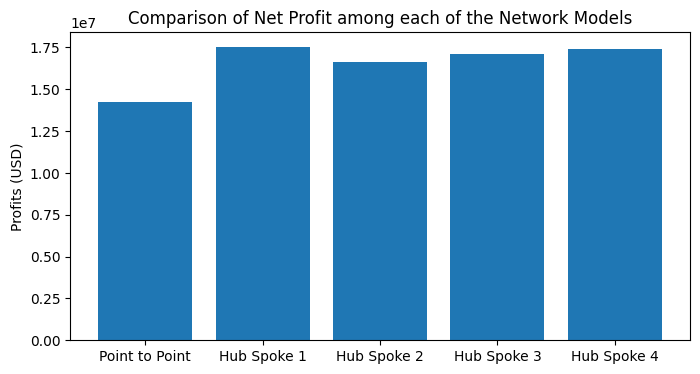

In [61]:
# compare profits among each of the models
fig_1 = plt.figure(figsize = (8,4), facecolor='w',edgecolor='k')

data_vec_mean = [np.mean(profits_vec), np.mean(profits_vec_h1), np.mean(profits_vec_h2), np.mean(profits_vec_h3), np.mean(profits_vec_h4)]
labels = ['Point to Point', 'Hub Spoke 1', 'Hub Spoke 2', 'Hub Spoke 3', 'Hub Spoke 4']
data_vec_std = [np.std(profits_vec), np.std(profits_vec_h1), np.std(profits_vec_h2), np.std(profits_vec_h3), np.std(profits_vec_h4)]
plt.bar(labels,data_vec_mean)
plt.title('Comparison of Net Profit among each of the Network Models')
plt.ylabel('Profits (USD)')

Text(0, 0.5, 'Departure Delay Time (min) per Passenger')

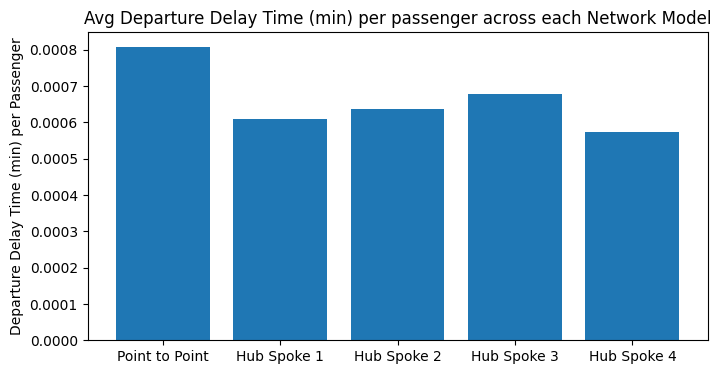

In [68]:
fig_1 = plt.figure(figsize = (8,4), facecolor='w',edgecolor='k')

data_vec_mean = [np.mean(dept_delay_vec)/np.mean(number_of_pass), np.mean(dept_delay_vec_h1)/np.mean(number_of_pass_h1), 
                 np.mean(dept_delay_vec_h2)/np.mean(number_of_pass_h2), np.mean(dept_delay_vec_h3)/np.mean(number_of_pass_h3), 
                 np.mean(dept_delay_vec_h4)/np.mean(number_of_pass_h4)]

labels = ['Point to Point', 'Hub Spoke 1', 'Hub Spoke 2', 'Hub Spoke 3', 'Hub Spoke 4']
data_vec_std = [np.std(profits_vec), np.std(profits_vec_h1), np.std(profits_vec_h2), np.std(profits_vec_h3), np.std(profits_vec_h4)]
plt.bar(labels,data_vec_mean)
plt.title('Avg Departure Delay Time (min) per passenger across each Network Model')
plt.ylabel('Departure Delay Time (min) per Passenger')

Text(0, 0.5, 'Arrival Delay Time (min) per Passenger')

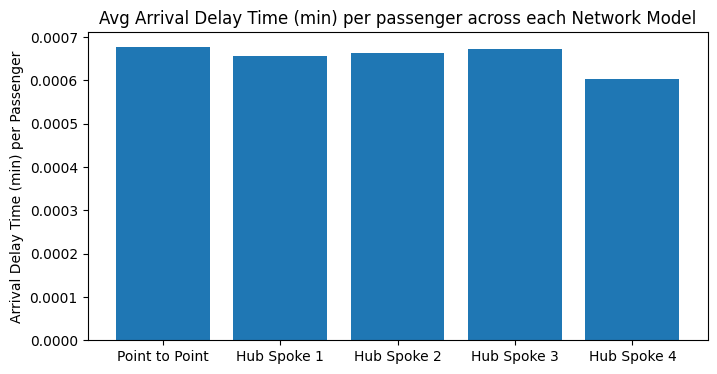

In [69]:
fig_1 = plt.figure(figsize = (8,4), facecolor='w',edgecolor='k')

data_vec_mean = [np.mean(arr_delay_vec)/np.mean(number_of_pass), np.mean(arr_delay_vec_h1)/np.mean(number_of_pass_h1), 
                 np.mean(arr_delay_vec_h2)/np.mean(number_of_pass_h2), np.mean(arr_delay_vec_h3)/np.mean(number_of_pass_h3), 
                 np.mean(arr_delay_vec_h4)/np.mean(number_of_pass_h4)]

labels = ['Point to Point', 'Hub Spoke 1', 'Hub Spoke 2', 'Hub Spoke 3', 'Hub Spoke 4']
data_vec_std = [np.std(profits_vec), np.std(profits_vec_h1), np.std(profits_vec_h2), np.std(profits_vec_h3), np.std(profits_vec_h4)]
plt.bar(labels,data_vec_mean)
plt.title('Avg Arrival Delay Time (min) per passenger across each Network Model')
plt.ylabel('Arrival Delay Time (min) per Passenger')

<BarContainer object of 5 artists>

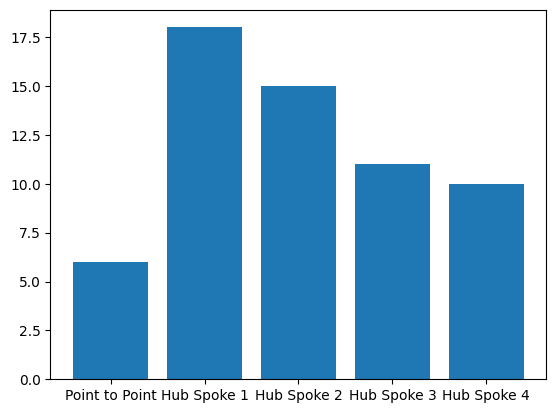

In [70]:
data_vec_mean = [sum(cancellations_vec), sum(cancellations_vec_h1), sum(cancellations_vec_h2), sum(cancellations_vec_h3), sum(cancellations_vec_h4)]
labels = ['Point to Point', 'Hub Spoke 1', 'Hub Spoke 2', 'Hub Spoke 3', 'Hub Spoke 4']
data_vec_std = [np.std(profits_vec), np.std(profits_vec_h1), np.std(profits_vec_h2), np.std(profits_vec_h3), np.std(profits_vec_h4)]
plt.bar(labels,data_vec_mean)

Text(0, 0.5, 'Number of Passengers')

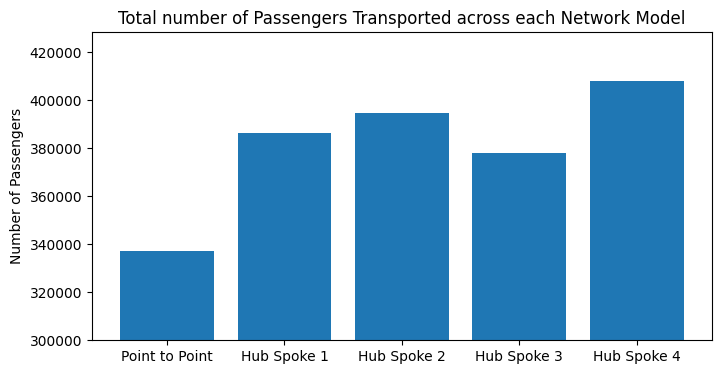

In [75]:
fig_1 = plt.figure(figsize = (8,4), facecolor='w',edgecolor='k')

data_vec_mean = [np.mean(number_of_pass), np.mean(number_of_pass_h1), 
                 np.mean(number_of_pass_h2), np.mean(number_of_pass_h3), 
                 np.mean(number_of_pass_h4)]

labels = ['Point to Point', 'Hub Spoke 1', 'Hub Spoke 2', 'Hub Spoke 3', 'Hub Spoke 4']
data_vec_std = [np.std(profits_vec), np.std(profits_vec_h1), np.std(profits_vec_h2), np.std(profits_vec_h3), np.std(profits_vec_h4)]
plt.bar(labels,data_vec_mean)
plt.ylim(300000)
plt.title('Total number of Passengers Transported across each Network Model')
plt.ylabel('Number of Passengers')